# Programming Exercise 2
**Christian Steinmetz**

Due on November 27th

Pick a binary classification dataset from the LIBSVM repository:
http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/


In [58]:
import sys
import time
import graphviz 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib as mpl

from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection

from matplotlib.colors import Normalize

mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

## Dataset
For this exercise we the [Mushrooms dataset](https://www.kaggle.com/uciml/mushroom-classification/data), which includes features from different mushroom species and a label of whether or not the mushroom is safe to eat or poisonous. For this task, given a set of mushroom features, we want to predict whether or not it is safe to eat the mushroom. 

<img src='https://images.unsplash.com/photo-1512595765784-5ebad80772a3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=800&q=60)' width=400>


## Loading and pre-processing
First we will load the data from the .csv file using pandas and then process it so that all of the features are encoded as numbers, since they are encoded as strings in the original dataset. We will then also split the data into instance features, $X$ and labels, $Y$.

In [3]:
df = pd.read_csv("./data/mushrooms.csv", dtype='category')
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [4]:
# use the label encoder to convert the string labels to integers
df = df.apply(preprocessing.LabelEncoder().fit_transform)

In [5]:
# this function lets us specifty a train/test split
# and then randomly sample datapoints for each set
def get_data(train_split):
    train_idx = np.random.choice(np.arange(len(df)), size=(train_split), replace=False)
    test_idx  = [idx for idx in np.arange(len(df)) if idx not in train_idx]

    y_train = df.loc[train_idx, 'class']
    x_train = df.loc[train_idx, df.columns != 'class']

    y_test = df.loc[test_idx, 'class']
    x_test = df.loc[test_idx, df.columns != 'class']
    
    return x_train, y_train, x_test, y_test

## 1. Decision Trees
Partition the dataset into a training and a testing set.
Run a decision tree learning algorithm usign the training set. Test the
decision tree on the testing dataset and report the total classification error
(i.e. 0/1 error). Repeat the experiment with a different partition. Plot
the resulting trees. Are they very similar, or very different? Explain why.

Advice: it can be convenient to set a maximum depth for the tree.

In [6]:
def graph_tree(trained_tree, name="tree"):
    dot_data = tree.export_graphviz(trained_tree,  
                    out_file=None, feature_names=df.columns[1:23],
                    class_names=["p", "e"], rounded=True, proportion=False, 
                    precision=2, filled = True)
    graph = graphviz.Source(dot_data) 
    graph.format = 'svg'
    graph.render(f"./plots/{name}") 
    return IFrame(f"./plots/{name}.svg", width='100%', height=800)

In [7]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))
clfA = tree.DecisionTreeClassifier(random_state=0, max_depth=4)
clfA = clfA.fit(x_train, y_train)
y_hat = clfA.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc)

0.9753846153846154


In [8]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))
clfB = tree.DecisionTreeClassifier(random_state=42, max_depth=4)
clfB = clfB.fit(x_train, y_train)
y_hat = clfB.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc)

0.9778461538461538


Let's observe the two different trees that were trained on different data

In [9]:
graph_tree(clfA, name="treeA")

In [10]:
graph_tree(clfB, name="treeB")

We notice that the two trees learn different things, but they do share some similiar qualities. This deviation between trees increases as the depth of the trees increase, since their are more degress of freedom. We actually found that when the depth was less than 3, with out dataset, both trees learned the same leaves, even with many different random samples of the data. 

In [89]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=7)
clf = clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc*100, "%")

100.0 %


With a depth of 7 we are able to get 100% accuracy on the test set.

## 2. Support Vector Machines
Run SVM to train a classifier, using radial basis as kernel function. Apply cross-validation to evaluate different
combinations of values of the model hyper-parameters (box constraint $C$
and kernel parameter $\gamma$). How sensitive is the cross-validation error to
changes in $C$ and $\gamma$? Choose the combination of $C$ and $\gamma$ that minimizes
the cross-validation error, train the SVM on the entire dataset and report
the total classification error.

Advice: use a logaritmic range for $\gamma$.

In [40]:
def train_svm(x_train, y_train, gamma, C):
    clf = svm.SVC(gamma=gamma, C=C, kernel="rbf")
    clf.fit(x_train, y_train)
    return clf

We will take 80% of the data and perform cross-validation on 5 folds of this data to exammine the performance of each SVM classifier as the values of $\gamma$ and $C$ are varied. Afterwards, we retrain the classifier that showed the lowest cross-validation error with the complete test set (80% of complete dataset) and then evaluate the final model on the remaining test set. 

In [66]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
scores = np.empty(shape=(len(C_range),len(gamma_range)))

for gamma_idx, gamma in enumerate(gamma_range):
    for C_idx, C in enumerate(C_range):
        clf = svm.SVC(gamma=gamma, C=C, kernel="rbf")
        scores[C_idx, gamma_idx] = model_selection.cross_val_score(clf, x_train, y_train, cv=5).mean()
        n_clf = gamma_idx*len(C_range) + C_idx
        total_clf = len(gamma_range)*len(C_range)
        sys.stdout.write(f"* Fit {n_clf+1:3d}/{total_clf:3d} SVM classifiers...\r")
        sys.stdout.flush()
print("Done.")

Done. 169/169 SVM classifiers...


After we have computed all the cross-validation scores across different values of $C$ and $\gamma$, we will make a plot to visualize the effect of these hyperparameters on the accuracy of the classifier. We modify [code](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) based on the documentation for sklearn to do this, where we make a heatmap showing the accuracy.  

In [67]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

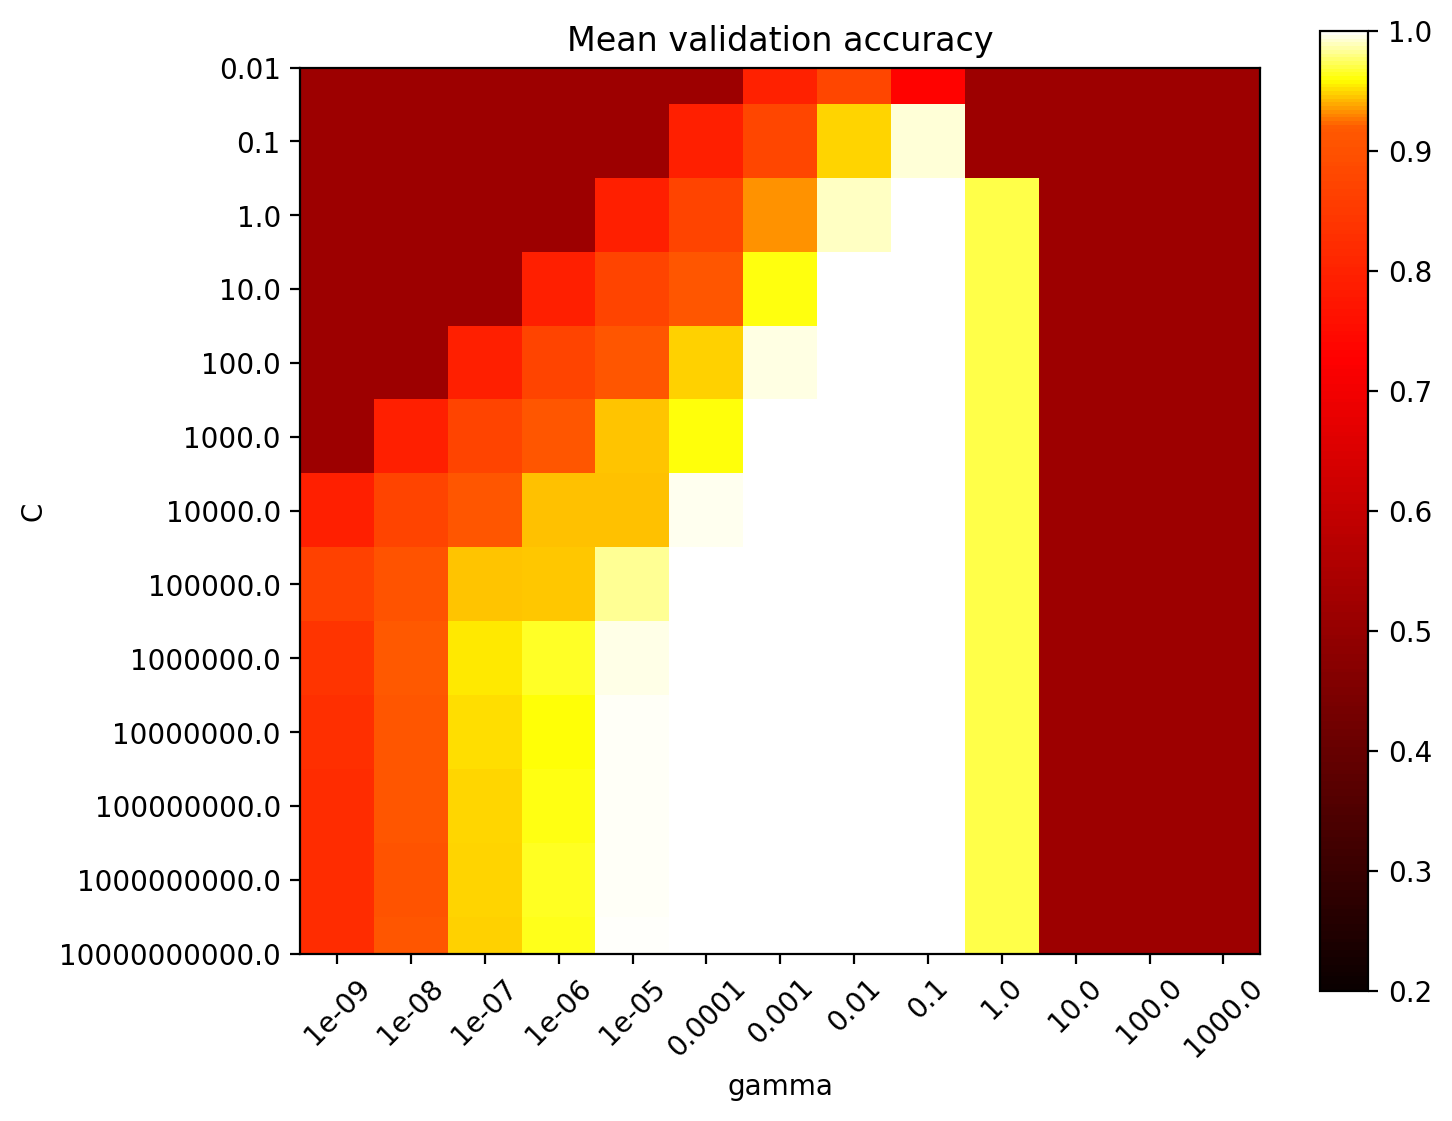

In [68]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Mean validation accuracy')
plt.show()

In [85]:
C_best_idx, gamma_best_idx = np.where(scores == np.amax(scores))
gamma_val_best = gamma_range[gamma_best_idx[0]]
C_val_best = C_range[C_best_idx[0]]
best_score = scores[C_best_idx[0], gamma_best_idx[0]]

print(f"Best results are given for gamma={gamma_val_best}a nd C={C_val_best} with acc={best_score*100}%")

Best results are given for gamma=0.1a nd C=1.0 with acc=100.0%


Our results above that there is a range of hyperparmaters over which our classifier is achieving 100% accuracy. We will retrain the SVM with these values and then evaluate on the test set, which has not been used at all during this process so far.

In [88]:
clf = svm.SVC(gamma=gamma_val_best, C=C_val_best, kernel="rbf")
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(f"{acc*100}%")

100.0%


## Neural Networks
Train a Multi-Layer perceptron using the crossentropy loss with $-2$ regularization (weight decay penalty). In other
words, the activation function equals the logistic function. Plot curves
of the training and validation error as a function of the penalty strength
$\alpha$. How do the curves behave? Explain why.

Advice: use a logaritmic range for hyper-parameter $\alpha$.. Experiment with
different sizes of the training/validation sets and different model parameters (network layers).